# 03 — Benchmark Analysis (Quantitative)

Analyze multi-model benchmark results from the full extraction pipeline:
detection rate, latency, per-joint confidence, correct vs incorrect comparison.

In [10]:
import sys
sys.path.insert(0, "..")

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from src.pose_estimation.keypoint_schema import UNIFIED_JOINTS

plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (12, 6)
sns.set_style("whitegrid")

BENCHMARK_DIR = Path("../data/processed/benchmark")
OUTPUT_DIR = Path("../outputs/results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## 1. Load Data

In [11]:
full_df = pd.read_csv(BENCHMARK_DIR / "full_benchmark.csv")
print(f"Full benchmark: {len(full_df)} rows")
print(f"Models: {full_df['model'].unique()}")
print(f"Videos: {full_df['video'].nunique()}")
print(f"Labels: {full_df['label'].value_counts().to_dict()}")
full_df.head()

Full benchmark: 21856 rows
Models: <StringArray>
['yolo', 'mediapipe']
Length: 2, dtype: str
Videos: 100
Labels: {'incorrect': 12850, 'correct': 9006}


,model,video,label,frame,detected,inference_ms,detection_confidence,conf_left_shoulder,conf_right_shoulder,conf_left_elbow,conf_right_elbow,conf_left_wrist,conf_right_wrist,conf_left_hip,conf_right_hip,conf_left_knee,conf_right_knee,conf_left_ankle,conf_right_ankle
0,yolo,Correct sequence/Copy of push up 1.mp4,correct,0,True,2366.967833,0.909349,0.983211,0.999292,0.769169,0.995492,0.549316,0.934504,0.974370,0.993263,0.902741,0.959890,0.643479,0.745430
1,yolo,Correct sequence/Copy of push up 1.mp4,correct,1,True,34.640917,0.910571,0.982976,0.999367,0.773895,0.996378,0.572915,0.947361,0.977852,0.994549,0.911720,0.966228,0.661895,0.769219
2,yolo,Correct sequence/Copy of push up 1.mp4,correct,2,True,26.263917,0.909070,0.954249,0.999373,0.462369,0.996763,0.318409,0.951638,0.965879,0.994770,0.904220,0.977885,0.736584,0.872768
3,yolo,Correct sequence/Copy of push up 1.mp4,correct,3,True,26.565542,0.909340,0.956251,0.999384,0.467648,0.996721,0.315358,0.950034,0.966699,0.994867,0.908664,0.978667,0.749177,0.879107
4,yolo,Correct sequence/Copy of push up 1.mp4,correct,4,True,25.126959,0.908118,0.965431,0.999323,0.527589,0.995975,0.349644,0.942083,0.971374,0.994837,0.923791,0.979562,0.788054,0.891210


In [12]:
latency_path = BENCHMARK_DIR / "latency_benchmark.csv"
if latency_path.exists():
    latency_df = pd.read_csv(latency_path)
    print("Latency benchmark loaded")
    display(latency_df)
else:
    latency_df = None
    print("No latency benchmark found — run BenchmarkRunner.run_latency_benchmark() first")

Latency benchmark loaded


,model,mean_ms,median_ms,std_ms,p95_ms,min_ms,max_ms,n_frames
0,YOLO (yolo11s-pose.pt),25.740910,24.382167,3.853348,33.243446,21.380875,43.390542,100
1,MediaPipe Pose (full),15.831949,15.542375,2.346143,19.943139,13.774959,30.845417,100


## 2. Detection Rate per Model

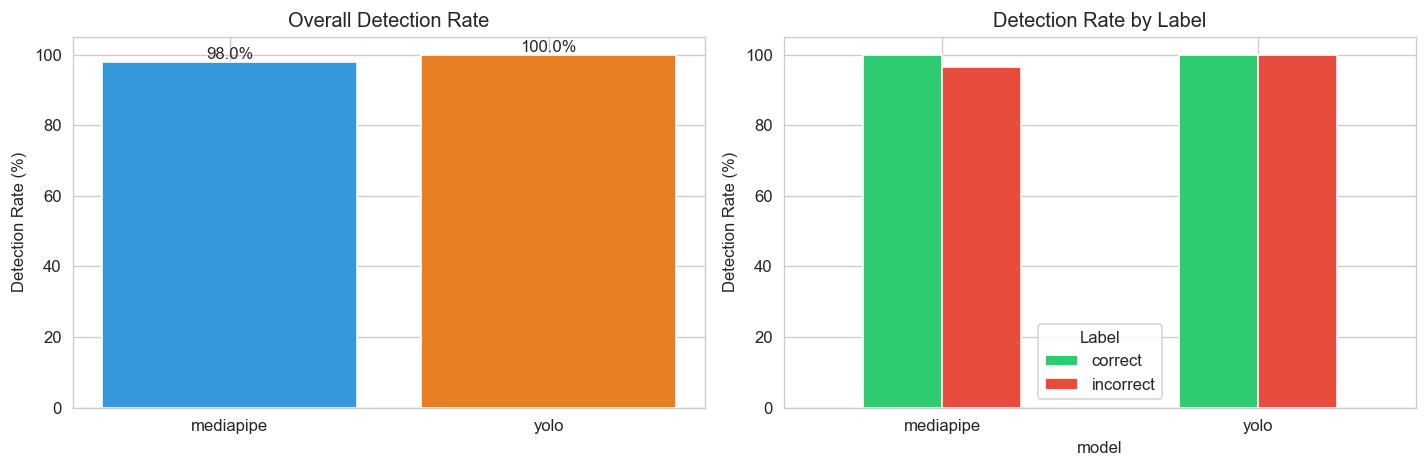

In [13]:
# Overall detection rate
det_rate = full_df.groupby("model")["detected"].mean() * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Overall
bars = axes[0].bar(det_rate.index, det_rate.values, color=["#3498db", "#e67e22"][:len(det_rate)])
axes[0].bar_label(bars, fmt="%.1f%%")
axes[0].set_ylabel("Detection Rate (%)")
axes[0].set_title("Overall Detection Rate")
axes[0].set_ylim(0, 105)

# By label
det_by_label = full_df.groupby(["model", "label"])["detected"].mean() * 100
det_by_label = det_by_label.unstack("label")
det_by_label.plot(kind="bar", ax=axes[1], color=["#2ecc71", "#e74c3c"], rot=0)
axes[1].set_ylabel("Detection Rate (%)")
axes[1].set_title("Detection Rate by Label")
axes[1].set_ylim(0, 105)
axes[1].legend(title="Label")

plt.tight_layout()
plt.show()

## 3. Latency Analysis

/var/folders/1q/pcrqby796fnbjgbr9ty_p12m0000gn/T/ipykernel_8324/122352023.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_box, labels=model_names, patch_artist=True, showfliers=False)


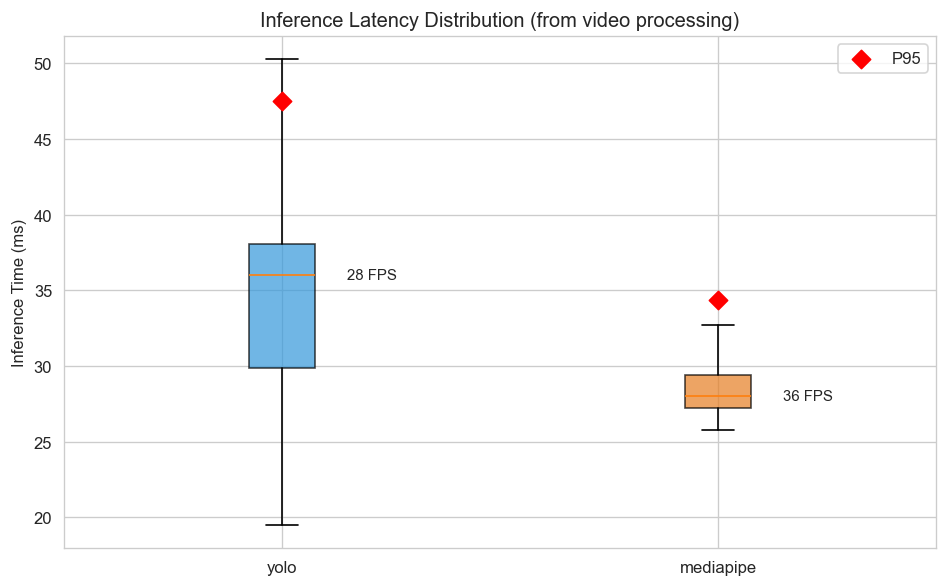

             count   mean    std    min    25%    50%    75%      max
model                                                                
mediapipe  10928.0  29.43   8.28  25.74  27.22  28.00  29.42   357.37
yolo       10928.0  36.61  34.49  19.48  29.87  36.03  38.06  2366.97


In [14]:
fig, ax = plt.subplots(figsize=(8, 5))

# Box plot of inference_ms from full benchmark
model_names = full_df["model"].unique()
data_for_box = [full_df[full_df["model"] == m]["inference_ms"].values for m in model_names]
bp = ax.boxplot(data_for_box, labels=model_names, patch_artist=True, showfliers=False)

colors = ["#3498db", "#e67e22"][:len(model_names)]
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Overlay P95
for i, m in enumerate(model_names):
    p95 = np.percentile(full_df[full_df["model"] == m]["inference_ms"], 95)
    median = np.median(full_df[full_df["model"] == m]["inference_ms"])
    ax.scatter(i + 1, p95, color="red", zorder=5, s=60, marker="D", label="P95" if i == 0 else None)
    fps = 1000 / median if median > 0 else 0
    ax.text(i + 1.15, median, f"{fps:.0f} FPS", fontsize=9, va="center")

ax.set_ylabel("Inference Time (ms)")
ax.set_title("Inference Latency Distribution (from video processing)")
ax.legend()
plt.tight_layout()
plt.show()

# Print latency stats
latency_stats = full_df.groupby("model")["inference_ms"].describe().round(2)
print(latency_stats)

## 4. Per-Joint Confidence Heatmap

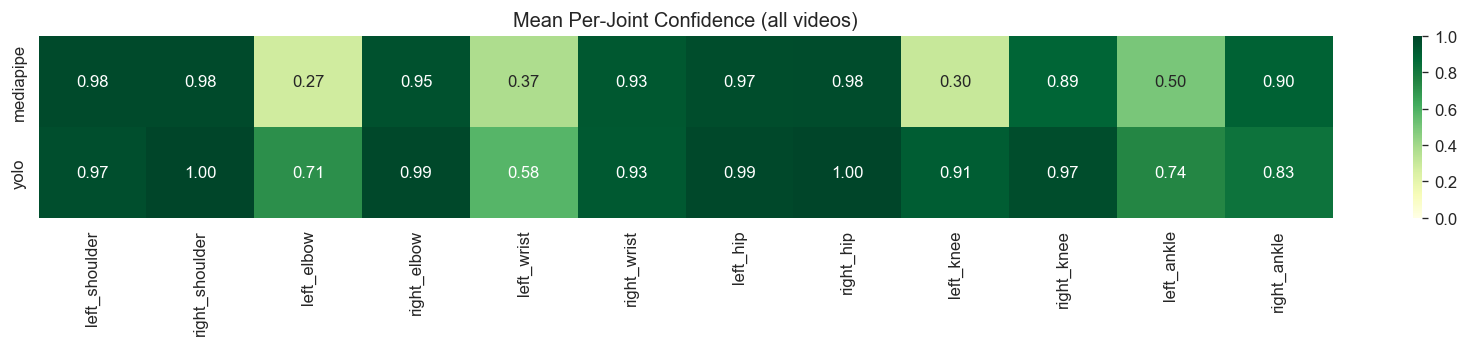

In [6]:
conf_cols = [f"conf_{j}" for j in UNIFIED_JOINTS]
conf_by_model = full_df.groupby("model")[conf_cols].mean()
conf_by_model.columns = UNIFIED_JOINTS  # cleaner labels

fig, ax = plt.subplots(figsize=(14, 3))
sns.heatmap(conf_by_model, annot=True, fmt=".2f", cmap="YlGn", vmin=0, vmax=1, ax=ax)
ax.set_title("Mean Per-Joint Confidence (all videos)")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

## 5. Confidence Over Time (Temporal Stability)

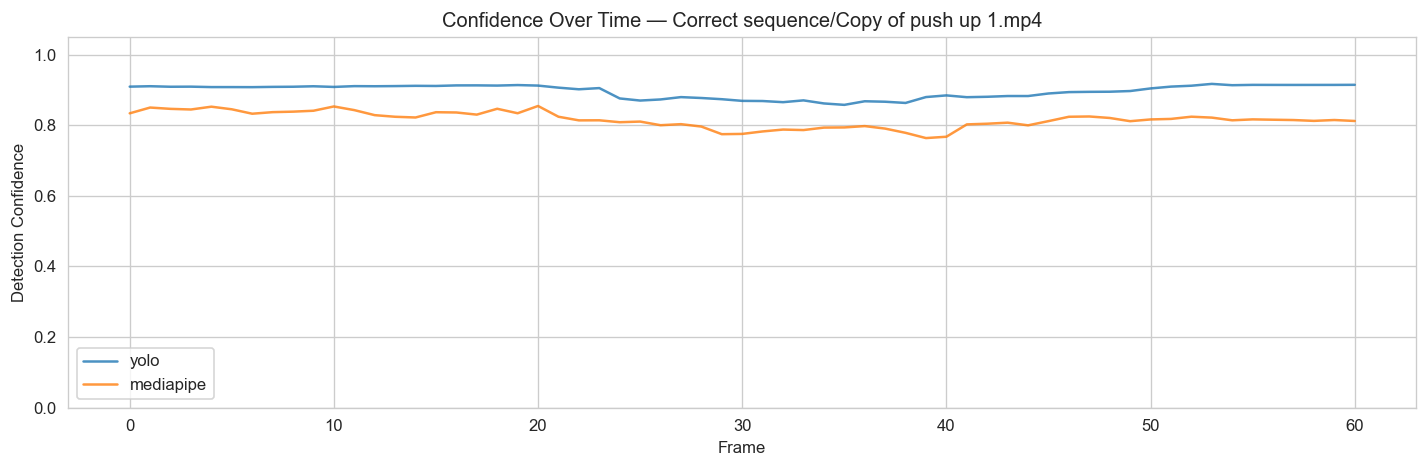

In [7]:
# Pick a single video to show temporal stability
sample_video = full_df["video"].unique()[0]
sample = full_df[full_df["video"] == sample_video]

fig, ax = plt.subplots(figsize=(12, 4))
for model_name in sample["model"].unique():
    subset = sample[sample["model"] == model_name]
    ax.plot(subset["frame"], subset["detection_confidence"], label=model_name, alpha=0.8)

ax.set_xlabel("Frame")
ax.set_ylabel("Detection Confidence")
ax.set_title(f"Confidence Over Time — {sample_video}")
ax.legend()
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

## 6. Correct vs Incorrect Comparison

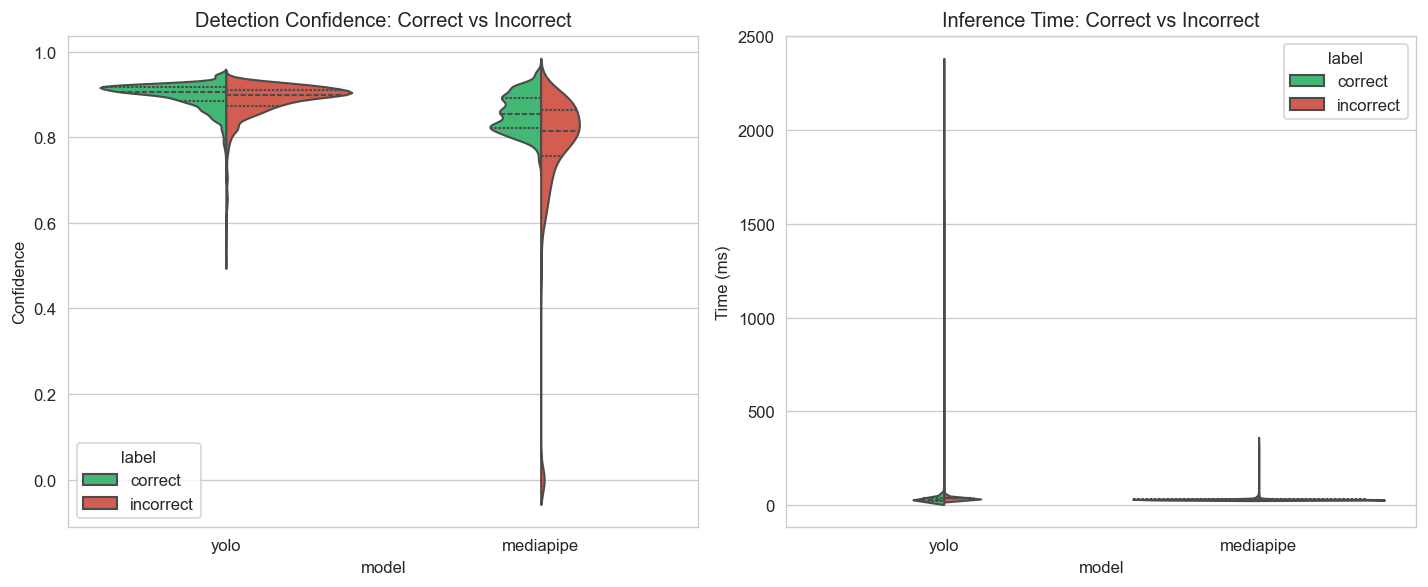

yolo: Mann-Whitney U = 17055338, p = 0.0000 *
mediapipe: Mann-Whitney U = 20565475, p = 0.0000 *


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Violin plot: detection confidence
sns.violinplot(
    data=full_df, x="model", y="detection_confidence", hue="label",
    split=True, palette={"correct": "#2ecc71", "incorrect": "#e74c3c"},
    ax=axes[0], inner="quartile"
)
axes[0].set_title("Detection Confidence: Correct vs Incorrect")
axes[0].set_ylabel("Confidence")

# Violin plot: inference time
sns.violinplot(
    data=full_df, x="model", y="inference_ms", hue="label",
    split=True, palette={"correct": "#2ecc71", "incorrect": "#e74c3c"},
    ax=axes[1], inner="quartile"
)
axes[1].set_title("Inference Time: Correct vs Incorrect")
axes[1].set_ylabel("Time (ms)")

plt.tight_layout()
plt.show()

# Statistical test: is detection confidence different for correct vs incorrect?
for model_name in full_df["model"].unique():
    correct = full_df[(full_df["model"] == model_name) & (full_df["label"] == "correct")]["detection_confidence"]
    incorrect = full_df[(full_df["model"] == model_name) & (full_df["label"] == "incorrect")]["detection_confidence"]
    stat, p = stats.mannwhitneyu(correct, incorrect, alternative="two-sided")
    print(f"{model_name}: Mann-Whitney U = {stat:.0f}, p = {p:.4f} {'*' if p < 0.05 else '(n.s.)'}")

## 7. Summary Table

In [9]:
summary_rows = []
for model_name in full_df["model"].unique():
    subset = full_df[full_df["model"] == model_name]
    median_ms = subset["inference_ms"].median()
    summary_rows.append({
        "Model": model_name,
        "Detection Rate (%)": round(subset["detected"].mean() * 100, 1),
        "Mean Confidence": round(subset["detection_confidence"].mean(), 3),
        "Median Latency (ms)": round(median_ms, 1),
        "P95 Latency (ms)": round(subset["inference_ms"].quantile(0.95), 1),
        "Effective FPS": round(1000 / median_ms, 1) if median_ms > 0 else 0,
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

# Save
summary_df.to_csv(OUTPUT_DIR / "benchmark_summary.csv", index=False)
print(f"\nSaved to {OUTPUT_DIR / 'benchmark_summary.csv'}")

,Model,Detection Rate (%),Mean Confidence,Median Latency (ms),P95 Latency (ms),Effective FPS
0,yolo,100.0,0.890,36.0,47.5,27.8
1,mediapipe,98.0,0.808,28.0,34.4,35.7



Saved to ../outputs/results/benchmark_summary.csv


## 8. Stress Test — Quantitative Robustness Analysis

Run both models on the stress test videos and compare against the clean Kaggle baseline.

In [15]:
import cv2
from src.pose_estimation import YoloEstimator, MediaPipeEstimator

STRESS_DIR = Path("../data/raw/stress_test")
CHALLENGE_TYPES = [
    "side_angle", "front_angle", "diagonal", "low_resolution",
    "poor_lighting", "noisy_compressed", "multiple_people",
]

# Discover stress test videos
stress_videos = {}
for challenge in CHALLENGE_TYPES:
    folder = STRESS_DIR / challenge
    if not folder.exists():
        continue
    vids = sorted(folder.glob("*.mp4")) + sorted(folder.glob("*.avi")) + sorted(folder.glob("*.mov"))
    if vids:
        stress_videos[challenge] = vids

total_stress = sum(len(v) for v in stress_videos.values())
print(f"Found {total_stress} stress test videos across {len(stress_videos)} categories")

if total_stress == 0:
    print("No stress test videos found — skipping Section 8.")

Found 11 stress test videos across 5 categories


In [16]:
if stress_videos:
    models = [YoloEstimator(), MediaPipeEstimator()]

    stress_rows = []
    for challenge, vids in stress_videos.items():
        for vpath in vids:
            cap = cv2.VideoCapture(str(vpath))
            n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            sample_indices = np.linspace(0, n_frames - 1, min(30, n_frames), dtype=int)

            for model in models:
                for idx in sample_indices:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
                    ret, frame = cap.read()
                    if not ret:
                        continue
                    result = model.predict_frame(frame)
                    row = {
                        "challenge": challenge,
                        "video": vpath.name,
                        "model": model.model_name,
                        "frame": int(idx),
                        "detected": result.detected,
                        "inference_ms": result.inference_time_ms,
                        "detection_confidence": result.detection_confidence,
                    }
                    for j, jname in enumerate(UNIFIED_JOINTS):
                        row[f"conf_{jname}"] = float(result.unified_keypoints[j, 2])
                    stress_rows.append(row)
            cap.release()

    stress_df = pd.DataFrame(stress_rows)
    print(f"Stress test: {len(stress_df)} frame-level rows collected")

    # Save for reproducibility
    stress_df.to_csv(BENCHMARK_DIR / "stress_benchmark.csv", index=False)
    print(f"Saved to {BENCHMARK_DIR / 'stress_benchmark.csv'}")

I0000 00:00:1770367826.123289 6319355 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1770367826.206946 6319356 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1770367826.219444 6319359 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


WARNING ⚠️ NMS time limit 2.050s exceeded


W0000 00:00:1770367838.083394 6319356 landmark_projection_calculator.cc:81] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Stress test: 592 frame-level rows collected
Saved to ../data/processed/benchmark/stress_benchmark.csv


### 8a. Detection Rate & Confidence — Clean vs Stress Test

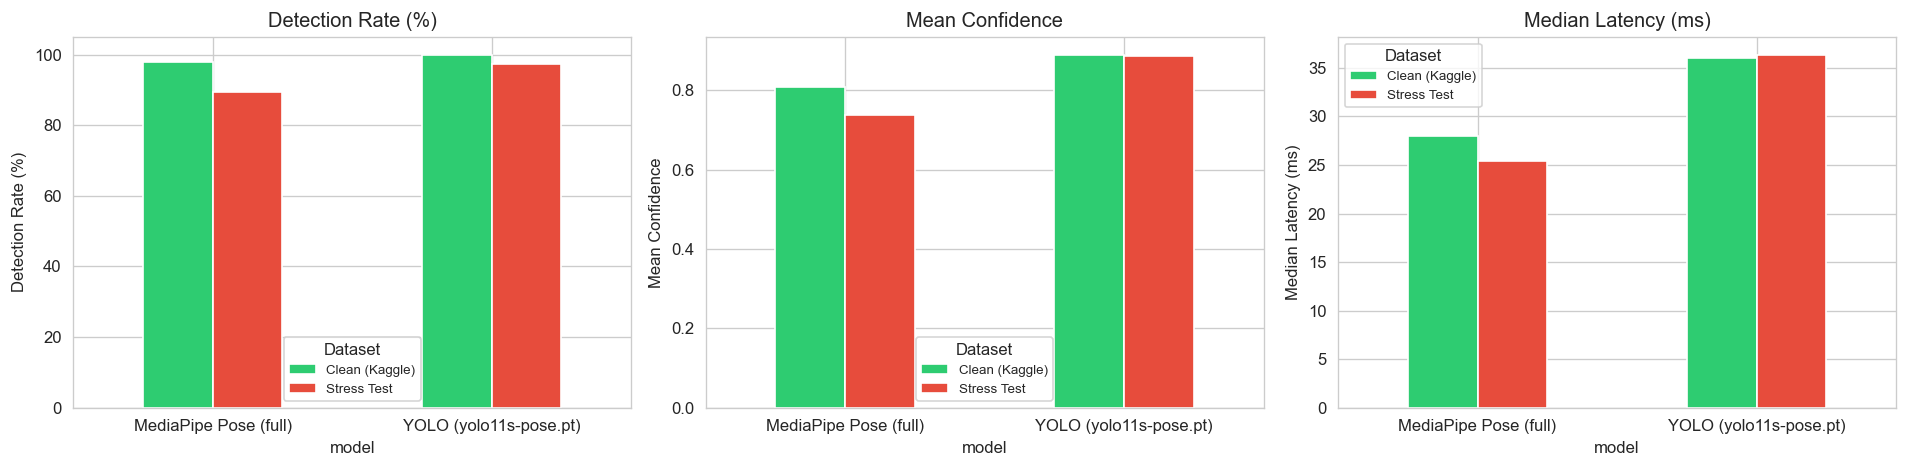

Degradation summary (Clean -> Stress):
  YOLO (yolo11s-pose.pt): det rate +2.7pp, confidence +0.003
  MediaPipe Pose (full): det rate +8.5pp, confidence +0.069


In [17]:
if stress_videos:
    # Build comparison table: clean vs stress per model
    comp_rows = []
    for model_name in stress_df["model"].unique():
        # Find matching model in clean data (name format may differ)
        clean_model = [m for m in full_df["model"].unique()
                       if m.lower().replace(" ", "") in model_name.lower().replace(" ", "")
                       or model_name.lower().replace(" ", "") in m.lower().replace(" ", "")]
        clean_key = clean_model[0] if clean_model else None

        stress_sub = stress_df[stress_df["model"] == model_name]
        comp_rows.append({
            "model": model_name,
            "dataset": "Stress Test",
            "detection_rate": stress_sub["detected"].mean() * 100,
            "mean_confidence": stress_sub["detection_confidence"].mean(),
            "median_latency_ms": stress_sub["inference_ms"].median(),
        })
        if clean_key:
            clean_sub = full_df[full_df["model"] == clean_key]
            comp_rows.append({
                "model": model_name,
                "dataset": "Clean (Kaggle)",
                "detection_rate": clean_sub["detected"].mean() * 100,
                "mean_confidence": clean_sub["detection_confidence"].mean(),
                "median_latency_ms": clean_sub["inference_ms"].median(),
            })

    comp_df = pd.DataFrame(comp_rows)

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    for i, metric in enumerate(["detection_rate", "mean_confidence", "median_latency_ms"]):
        pivot = comp_df.pivot(index="model", columns="dataset", values=metric)
        pivot.plot(kind="bar", ax=axes[i], rot=0, color=["#2ecc71", "#e74c3c"])
        labels = {"detection_rate": "Detection Rate (%)", "mean_confidence": "Mean Confidence",
                  "median_latency_ms": "Median Latency (ms)"}
        axes[i].set_ylabel(labels[metric])
        axes[i].set_title(labels[metric])
        axes[i].legend(title="Dataset", fontsize=8)
    plt.tight_layout()
    plt.show()

    # Degradation summary
    print("Degradation summary (Clean -> Stress):")
    for model_name in stress_df["model"].unique():
        clean_row = comp_df[(comp_df["model"] == model_name) & (comp_df["dataset"] == "Clean (Kaggle)")]
        stress_row = comp_df[(comp_df["model"] == model_name) & (comp_df["dataset"] == "Stress Test")]
        if not clean_row.empty and not stress_row.empty:
            det_drop = clean_row.iloc[0]["detection_rate"] - stress_row.iloc[0]["detection_rate"]
            conf_drop = clean_row.iloc[0]["mean_confidence"] - stress_row.iloc[0]["mean_confidence"]
            print(f"  {model_name}: det rate {det_drop:+.1f}pp, confidence {conf_drop:+.3f}")

### 8b. Detection Rate by Challenge Type

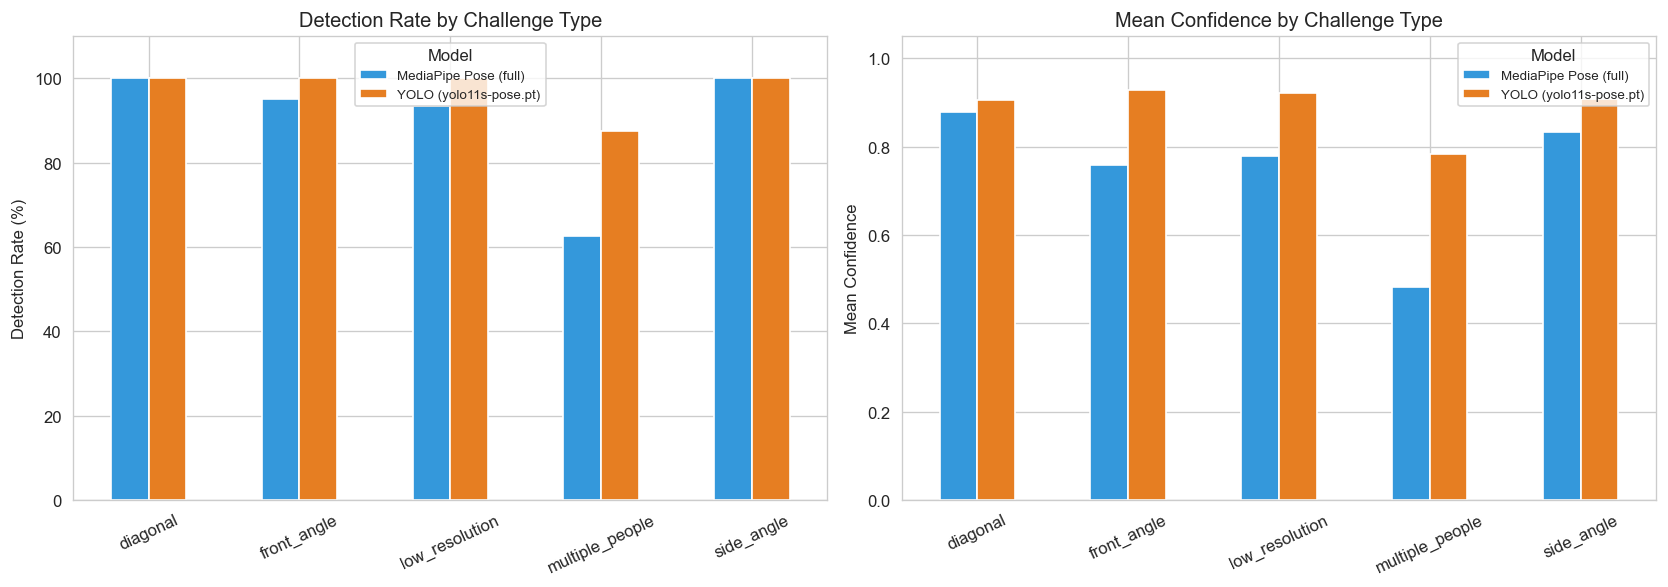

detection_rate                         \
model           MediaPipe Pose (full) YOLO (yolo11s-pose.pt)   
challenge                                                      
diagonal                        100.0                  100.0   
front_angle                      95.0                  100.0   
low_resolution                   93.3                  100.0   
multiple_people                  62.5                   87.5   
side_angle                      100.0                  100.0   

                      mean_confidence                         \
model           MediaPipe Pose (full) YOLO (yolo11s-pose.pt)   
challenge                                                      
diagonal                        0.879                  0.905   
front_angle                     0.759                  0.928   
low_resolution                  0.778                  0.921   
multiple_people                 0.482                  0.783   
side_angle                      0.832                  0.907   

                             n_frames                         
model           MediaPipe Pose (full) YOLO (yolo11s-pose.pt)  
challenge                                                     
diagonal                           52                     52  
front_angle                        60                     60  
low_resolution                     60                     60  
multiple_people                    64                     64  
side_angle                         60                     60

In [18]:
if stress_videos:
    # Detection rate and confidence breakdown per challenge
    challenge_stats = stress_df.groupby(["challenge", "model"]).agg(
        detection_rate=("detected", "mean"),
        mean_confidence=("detection_confidence", "mean"),
        n_frames=("detected", "count"),
    ).round(3)
    challenge_stats["detection_rate"] *= 100

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Detection rate
    det_pivot = challenge_stats["detection_rate"].unstack("model")
    det_pivot.plot(kind="bar", ax=axes[0], rot=25, color=["#3498db", "#e67e22"])
    axes[0].set_ylabel("Detection Rate (%)")
    axes[0].set_title("Detection Rate by Challenge Type")
    axes[0].set_ylim(0, 110)
    axes[0].legend(title="Model", fontsize=8)
    axes[0].set_xlabel("")

    # Mean confidence
    conf_pivot = challenge_stats["mean_confidence"].unstack("model")
    conf_pivot.plot(kind="bar", ax=axes[1], rot=25, color=["#3498db", "#e67e22"])
    axes[1].set_ylabel("Mean Confidence")
    axes[1].set_title("Mean Confidence by Challenge Type")
    axes[1].set_ylim(0, 1.05)
    axes[1].legend(title="Model", fontsize=8)
    axes[1].set_xlabel("")

    plt.tight_layout()
    plt.show()

    display(challenge_stats.unstack("model"))

### 8c. Per-Joint Confidence Heatmap — Stress Test

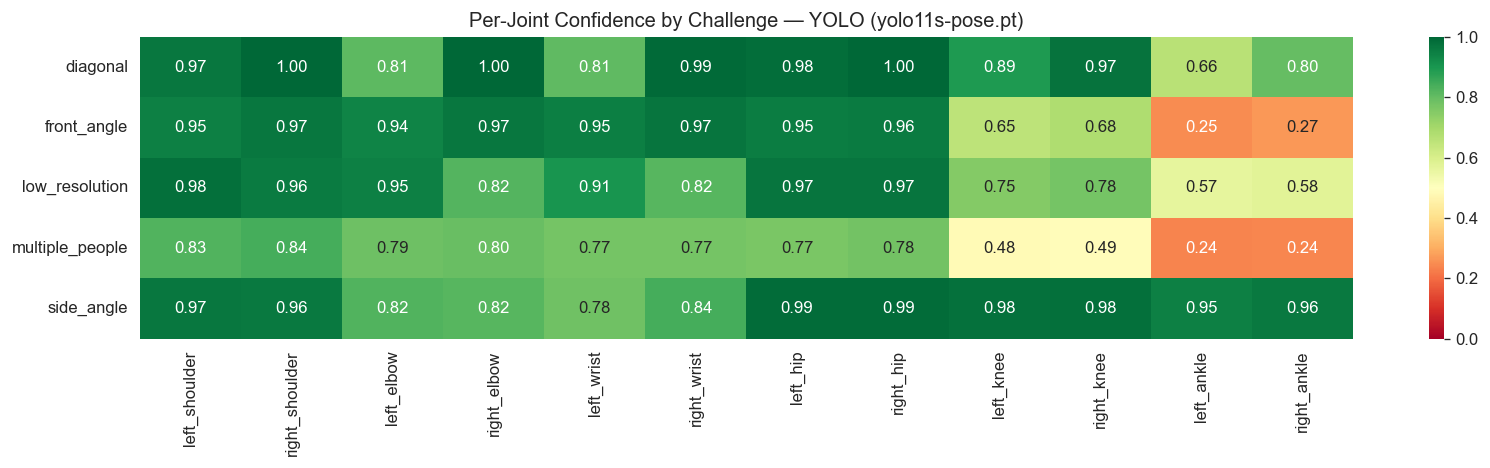

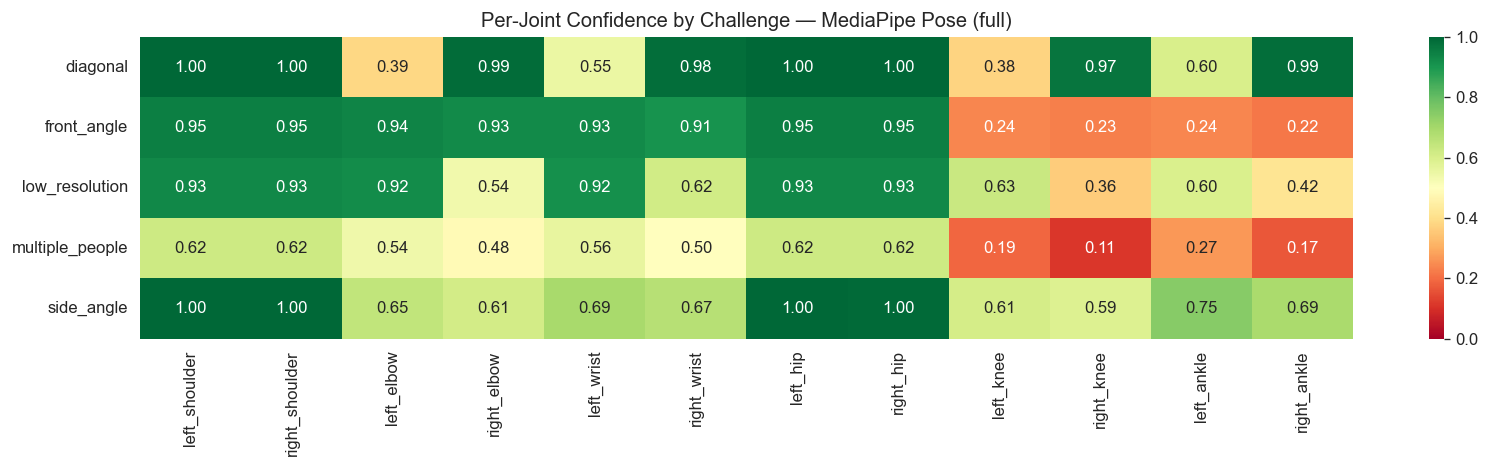

In [19]:
if stress_videos:
    conf_cols = [f"conf_{j}" for j in UNIFIED_JOINTS]

    for model_name in stress_df["model"].unique():
        subset = stress_df[stress_df["model"] == model_name]
        pivot = subset.groupby("challenge")[conf_cols].mean()
        pivot.columns = UNIFIED_JOINTS

        fig, ax = plt.subplots(figsize=(14, max(3, len(pivot) * 0.8)))
        sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlGn", vmin=0, vmax=1, ax=ax)
        ax.set_title(f"Per-Joint Confidence by Challenge — {model_name}")
        ax.set_ylabel("")
        plt.tight_layout()
        plt.show()

### 8d. Updated Summary Table (Clean + Stress)

In [20]:
if stress_videos:
    full_summary_rows = []
    for model_name in stress_df["model"].unique():
        stress_sub = stress_df[stress_df["model"] == model_name]
        stress_median = stress_sub["inference_ms"].median()

        # Find matching clean model
        clean_model = [m for m in full_df["model"].unique()
                       if m.lower().replace(" ", "") in model_name.lower().replace(" ", "")
                       or model_name.lower().replace(" ", "") in m.lower().replace(" ", "")]
        clean_key = clean_model[0] if clean_model else None

        row = {"Model": model_name}
        if clean_key:
            clean_sub = full_df[full_df["model"] == clean_key]
            row["Clean Det Rate (%)"] = round(clean_sub["detected"].mean() * 100, 1)
            row["Clean Mean Conf"] = round(clean_sub["detection_confidence"].mean(), 3)
        row["Stress Det Rate (%)"] = round(stress_sub["detected"].mean() * 100, 1)
        row["Stress Mean Conf"] = round(stress_sub["detection_confidence"].mean(), 3)
        if clean_key:
            row["Det Rate Drop (pp)"] = round(row["Clean Det Rate (%)"] - row["Stress Det Rate (%)"], 1)
            row["Conf Drop"] = round(row["Clean Mean Conf"] - row["Stress Mean Conf"], 3)
        row["Stress Median ms"] = round(stress_median, 1)
        full_summary_rows.append(row)

    full_summary = pd.DataFrame(full_summary_rows)
    display(full_summary)

    full_summary.to_csv(OUTPUT_DIR / "benchmark_summary_with_stress.csv", index=False)
    print(f"Saved to {OUTPUT_DIR / 'benchmark_summary_with_stress.csv'}")

,Model,Clean Det Rate (%),Clean Mean Conf,Stress Det Rate (%),Stress Mean Conf,Det Rate Drop (pp),Conf Drop,Stress Median ms
0,YOLO (yolo11s-pose.pt),100.0,0.890,97.3,0.887,2.7,0.003,36.4
1,MediaPipe Pose (full),98.0,0.808,89.5,0.739,8.5,0.069,25.4


Saved to ../outputs/results/benchmark_summary_with_stress.csv


## 9. Conclusions

**Clean dataset (Sections 1-7):**
- See Section 7 summary table for per-model stats on the 100-video Kaggle benchmark

**Stress test (Section 8):**
- Key questions answered:
  1. Which model degrades more gracefully under challenging conditions?
  2. Which challenge type causes the largest detection rate drop?
  3. Which joints lose confidence first?
  4. Does the degradation warrant preprocessing for deployment?

**Model recommendation:**
- Fill in after running the notebook with the stress test results
- Consider the tradeoff: detection robustness vs latency vs joint confidence

A teammate can later add MoveNet or RTMPose as additional comparison points.